# Gathering Stage

In [1]:
# Gathering Stage of the Data Wrangling process
# impoting all the libraries that will be used in the code
import pandas as pd
import requests
import os
import tweepy
import datetime
import json
import numpy as np
import re
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

In [2]:
# loading file twitter-archive-enhanced.csv into a pandas data frame and checking the first 5 rows of the data
df_twt_arch = pd.read_csv('twitter-archive-enhanced.csv')
df_twt_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# downloading the image predictions file from its url using requests library
img_pred_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
res = requests.get(img_pred_url)

In [4]:
# saving the image predictions file locally 
with open(os.path.join(os.getcwd(), 
         img_pred_url.split('/')[-1]), mode='wb') as file:
    file.write(res.content)

In [5]:
# loading image predictions file into a data frame
df_img_pred =  pd.read_csv('image-predictions.tsv', sep='\t')
df_img_pred.sample(7)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
349,672482722825261057,https://pbs.twimg.com/media/CVUjd14W4AE8tvO.jpg,1,West_Highland_white_terrier,0.586173,True,borzoi,0.206620,True,Great_Pyrenees,0.060653,True
1773,828011680017821696,https://pbs.twimg.com/media/C32wOLcWYAAjNqS.jpg,1,American_Staffordshire_terrier,0.936662,True,Staffordshire_bullterrier,0.032999,True,bull_mastiff,0.017183,True
709,685268753634967552,https://pbs.twimg.com/media/CYKQS0xUQAEOptC.jpg,1,pug,0.999044,True,Norwegian_elkhound,0.000547,True,bull_mastiff,0.000235,True
622,680497766108381184,https://pbs.twimg.com/media/CXGdG0aWcAEbOO1.jpg,1,Chihuahua,0.538354,True,muzzle,0.084289,False,ski_mask,0.076690,False
1853,840696689258311684,https://pbs.twimg.com/media/C6rBLenU0AAr8MN.jpg,1,web_site,0.841768,False,rule,0.007087,False,envelope,0.006820,False
273,670832455012716544,https://pbs.twimg.com/media/CU9GjzrUkAAWPh4.jpg,1,malinois,0.317607,True,Norwegian_elkhound,0.274901,True,bathing_cap,0.114643,False
579,678764513869611008,https://pbs.twimg.com/media/CWt0ubZWcAAkFER.jpg,1,Irish_terrier,0.696646,True,Australian_terrier,0.074962,True,Irish_setter,0.063901,True


In [6]:
#fetching the tweets from the Twitter API.
from tweepy import OAuthHandler
consumer_key = 'REMOVED'
consumer_secret = 'REMOVED'
access_token = 'REMOVED'
access_secret = 'REMOVED'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [7]:
#Query the Twitter APIs for each tweet's JSON 

Missing_tweets = []

with open(os.path.join(os.getcwd(), 'tweet_json.txt'), mode = 'w') as file:
    for tweet_id in df_twt_arch['tweet_id']:
        try:
            print('-'*20)
            print('Tweet_id:  {}  initiated at:  {} '.format( tweet_id, datetime.datetime.now().time()))
            tweet = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            file.write(json.dumps(tweet._json) + '\n')
            print(' and completed at:  {}'.format( datetime.datetime.now().time()))        
        except:
            print('Missing Tweet:'+ str(tweet_id))
            Missing_tweets.append(tweet_id)
             
print("Finished Querying All Tweets")



--------------------
Tweet_id:  892420643555336193  initiated at:  06:48:01.915132 
 and completed at:  06:48:03.093470
--------------------
Tweet_id:  892177421306343426  initiated at:  06:48:03.093637 
 and completed at:  06:48:03.945157
--------------------
Tweet_id:  891815181378084864  initiated at:  06:48:03.945299 
 and completed at:  06:48:05.615268
--------------------
Tweet_id:  891689557279858688  initiated at:  06:48:05.615413 
 and completed at:  06:48:06.519737
--------------------
Tweet_id:  891327558926688256  initiated at:  06:48:06.519860 
 and completed at:  06:48:08.055031
--------------------
Tweet_id:  891087950875897856  initiated at:  06:48:08.055192 
 and completed at:  06:48:09.591701
--------------------
Tweet_id:  890971913173991426  initiated at:  06:48:09.591821 
 and completed at:  06:48:11.125635
--------------------
Tweet_id:  890729181411237888  initiated at:  06:48:11.125753 
 and completed at:  06:48:13.585123
--------------------
Tweet_id:  89060918

 and completed at:  06:49:27.764095
--------------------
Tweet_id:  879050749262655488  initiated at:  06:49:27.764268 
 and completed at:  06:49:28.867644
--------------------
Tweet_id:  879008229531029506  initiated at:  06:49:28.867766 
 and completed at:  06:49:29.833325
--------------------
Tweet_id:  878776093423087618  initiated at:  06:49:29.833495 
 and completed at:  06:49:30.996977
--------------------
Tweet_id:  878604707211726852  initiated at:  06:49:30.997120 
 and completed at:  06:49:32.536572
--------------------
Tweet_id:  878404777348136964  initiated at:  06:49:32.536701 
 and completed at:  06:49:33.816450
--------------------
Tweet_id:  878316110768087041  initiated at:  06:49:33.816591 
 and completed at:  06:49:34.991780
--------------------
Tweet_id:  878281511006478336  initiated at:  06:49:34.991940 
 and completed at:  06:49:36.531289
--------------------
Tweet_id:  878057613040115712  initiated at:  06:49:36.531425 
 and completed at:  06:49:37.518365
----

 and completed at:  06:50:50.564595
--------------------
Tweet_id:  865718153858494464  initiated at:  06:50:50.564716 
 and completed at:  06:50:51.793237
--------------------
Tweet_id:  865359393868664832  initiated at:  06:50:51.793387 
 and completed at:  06:50:53.019455
--------------------
Tweet_id:  865006731092295680  initiated at:  06:50:53.019598 
 and completed at:  06:50:53.913570
--------------------
Tweet_id:  864873206498414592  initiated at:  06:50:53.913691 
 and completed at:  06:50:54.865251
--------------------
Tweet_id:  864279568663928832  initiated at:  06:50:54.865371 
 and completed at:  06:50:56.093977
--------------------
Tweet_id:  864197398364647424  initiated at:  06:50:56.094097 
 and completed at:  06:50:58.244639
--------------------
Tweet_id:  863907417377173506  initiated at:  06:50:58.244759 
 and completed at:  06:50:59.473140
--------------------
Tweet_id:  863553081350529029  initiated at:  06:50:59.473259 
 and completed at:  06:51:00.395098
----

 and completed at:  06:52:10.696215
--------------------
Tweet_id:  852553447878664193  initiated at:  06:52:10.696358 
 and completed at:  06:52:12.280013
--------------------
Tweet_id:  852311364735569921  initiated at:  06:52:12.280134 
 and completed at:  06:52:13.815695
--------------------
Tweet_id:  852226086759018497  initiated at:  06:52:13.815815 
 and completed at:  06:52:14.735741
--------------------
Tweet_id:  852189679701164033  initiated at:  06:52:14.735860 
 and completed at:  06:52:15.602953
--------------------
Tweet_id:  851953902622658560  initiated at:  06:52:15.603114 
Missing Tweet:851953902622658560
--------------------
Tweet_id:  851861385021730816  initiated at:  06:52:16.843338 
 and completed at:  06:52:18.114638
--------------------
Tweet_id:  851591660324737024  initiated at:  06:52:18.114859 
 and completed at:  06:52:19.147159
--------------------
Tweet_id:  851464819735769094  initiated at:  06:52:19.147307 
 and completed at:  06:52:20.295632
-------

 and completed at:  06:53:38.603640
--------------------
Tweet_id:  840632337062862849  initiated at:  06:53:38.603816 
 and completed at:  06:53:40.082221
--------------------
Tweet_id:  840370681858686976  initiated at:  06:53:40.082369 
 and completed at:  06:53:41.207312
--------------------
Tweet_id:  840268004936019968  initiated at:  06:53:41.207457 
 and completed at:  06:53:42.051029
--------------------
Tweet_id:  839990271299457024  initiated at:  06:53:42.051212 
 and completed at:  06:53:43.224028
--------------------
Tweet_id:  839549326359670784  initiated at:  06:53:43.224144 
 and completed at:  06:53:44.114035
--------------------
Tweet_id:  839290600511926273  initiated at:  06:53:44.114216 
 and completed at:  06:53:45.015960
--------------------
Tweet_id:  839239871831150596  initiated at:  06:53:45.016113 
 and completed at:  06:53:46.166760
--------------------
Tweet_id:  838952994649550848  initiated at:  06:53:46.166876 
 and completed at:  06:53:47.078928
----

 and completed at:  06:55:00.644225
--------------------
Tweet_id:  831939777352105988  initiated at:  06:55:00.644394 
 and completed at:  06:55:02.482561
--------------------
Tweet_id:  831926988323639298  initiated at:  06:55:02.482689 
 and completed at:  06:55:03.406790
--------------------
Tweet_id:  831911600680497154  initiated at:  06:55:03.406910 
 and completed at:  06:55:05.026097
--------------------
Tweet_id:  831670449226514432  initiated at:  06:55:05.026254 
 and completed at:  06:55:06.169814
--------------------
Tweet_id:  831650051525054464  initiated at:  06:55:06.169936 
 and completed at:  06:55:07.110820
--------------------
Tweet_id:  831552930092285952  initiated at:  06:55:07.110943 
 and completed at:  06:55:08.321267
--------------------
Tweet_id:  831322785565769729  initiated at:  06:55:08.321439 
 and completed at:  06:55:09.279670
--------------------
Tweet_id:  831315979191906304  initiated at:  06:55:09.279820 
 and completed at:  06:55:11.089137
----

 and completed at:  06:56:27.596980
--------------------
Tweet_id:  822859134160621569  initiated at:  06:56:27.597107 
 and completed at:  06:56:28.500265
--------------------
Tweet_id:  822647212903690241  initiated at:  06:56:28.500385 
 and completed at:  06:56:29.731736
--------------------
Tweet_id:  822610361945911296  initiated at:  06:56:29.731858 
 and completed at:  06:56:30.958691
--------------------
Tweet_id:  822489057087389700  initiated at:  06:56:30.958838 
 and completed at:  06:56:31.880172
--------------------
Tweet_id:  822462944365645825  initiated at:  06:56:31.880308 
 and completed at:  06:56:33.454114
--------------------
Tweet_id:  822244816520155136  initiated at:  06:56:33.454233 
 and completed at:  06:56:34.974950
--------------------
Tweet_id:  822163064745328640  initiated at:  06:56:34.975070 
 and completed at:  06:56:36.183173
--------------------
Tweet_id:  821886076407029760  initiated at:  06:56:36.183310 
 and completed at:  06:56:37.149598
----

 and completed at:  06:57:47.463228
--------------------
Tweet_id:  814986499976527872  initiated at:  06:57:47.463348 
 and completed at:  06:57:48.700528
--------------------
Tweet_id:  814638523311648768  initiated at:  06:57:48.700649 
 and completed at:  06:57:50.230859
--------------------
Tweet_id:  814578408554463233  initiated at:  06:57:50.230980 
 and completed at:  06:57:51.444918
--------------------
Tweet_id:  814530161257443328  initiated at:  06:57:51.445038 
 and completed at:  06:57:53.299438
--------------------
Tweet_id:  814153002265309185  initiated at:  06:57:53.299572 
 and completed at:  06:57:54.769833
--------------------
Tweet_id:  813944609378369540  initiated at:  06:57:54.769990 
 and completed at:  06:57:55.746573
--------------------
Tweet_id:  813910438903693312  initiated at:  06:57:55.746694 
 and completed at:  06:57:57.282168
--------------------
Tweet_id:  813812741911748608  initiated at:  06:57:57.282287 
 and completed at:  06:57:58.203482
----

 and completed at:  06:59:13.237527
--------------------
Tweet_id:  804413760345620481  initiated at:  06:59:13.237649 
 and completed at:  06:59:14.095042
--------------------
Tweet_id:  804026241225523202  initiated at:  06:59:14.095210 
 and completed at:  06:59:15.067741
--------------------
Tweet_id:  803773340896923648  initiated at:  06:59:15.067863 
 and completed at:  06:59:16.253409
--------------------
Tweet_id:  803692223237865472  initiated at:  06:59:16.253530 
 and completed at:  06:59:17.563362
--------------------
Tweet_id:  803638050916102144  initiated at:  06:59:17.563483 
 and completed at:  06:59:18.768920
--------------------
Tweet_id:  803380650405482500  initiated at:  06:59:18.769048 
 and completed at:  06:59:20.078158
--------------------
Tweet_id:  803321560782307329  initiated at:  06:59:20.078304 
 and completed at:  06:59:21.157521
--------------------
Tweet_id:  803276597545603072  initiated at:  06:59:21.157642 
 and completed at:  06:59:22.069732
----

 and completed at:  07:00:34.170132
--------------------
Tweet_id:  796116448414461957  initiated at:  07:00:34.170283 
 and completed at:  07:00:35.183082
--------------------
Tweet_id:  796080075804475393  initiated at:  07:00:35.183200 
 and completed at:  07:00:36.341331
--------------------
Tweet_id:  796031486298386433  initiated at:  07:00:36.341451 
 and completed at:  07:00:37.173740
--------------------
Tweet_id:  795464331001561088  initiated at:  07:00:37.173861 
 and completed at:  07:00:38.561413
--------------------
Tweet_id:  795400264262053889  initiated at:  07:00:38.561562 
 and completed at:  07:00:39.800500
--------------------
Tweet_id:  795076730285391872  initiated at:  07:00:39.800621 
 and completed at:  07:00:41.025088
--------------------
Tweet_id:  794983741416415232  initiated at:  07:00:41.025250 
 and completed at:  07:00:42.272002
--------------------
Tweet_id:  794926597468000259  initiated at:  07:00:42.272125 
 and completed at:  07:00:43.708193
----

 and completed at:  07:01:56.283626
--------------------
Tweet_id:  787397959788929025  initiated at:  07:01:56.283747 
 and completed at:  07:01:57.206416
--------------------
Tweet_id:  787322443945877504  initiated at:  07:01:57.206534 
 and completed at:  07:01:58.154771
--------------------
Tweet_id:  787111942498508800  initiated at:  07:01:58.154891 
 and completed at:  07:01:59.103569
--------------------
Tweet_id:  786963064373534720  initiated at:  07:01:59.103689 
 and completed at:  07:02:00.582490
--------------------
Tweet_id:  786729988674449408  initiated at:  07:02:00.582611 
 and completed at:  07:02:01.757541
--------------------
Tweet_id:  786709082849828864  initiated at:  07:02:01.757660 
 and completed at:  07:02:02.976853
--------------------
Tweet_id:  786664955043049472  initiated at:  07:02:02.976971 
 and completed at:  07:02:03.963672
--------------------
Tweet_id:  786595970293370880  initiated at:  07:02:03.963794 
 and completed at:  07:02:05.086269
----

 and completed at:  07:03:19.842991
--------------------
Tweet_id:  778396591732486144  initiated at:  07:03:19.843141 
 and completed at:  07:03:24.839708
--------------------
Tweet_id:  778383385161035776  initiated at:  07:03:24.839830 
 and completed at:  07:03:25.914297
--------------------
Tweet_id:  778286810187399168  initiated at:  07:03:25.914451 
 and completed at:  07:03:27.351261
--------------------
Tweet_id:  778039087836069888  initiated at:  07:03:27.351382 
 and completed at:  07:03:28.670894
--------------------
Tweet_id:  778027034220126208  initiated at:  07:03:28.671016 
 and completed at:  07:03:29.679934
--------------------
Tweet_id:  777953400541634568  initiated at:  07:03:29.680055 
 and completed at:  07:03:30.701817
--------------------
Tweet_id:  777885040357281792  initiated at:  07:03:30.701955 
 and completed at:  07:03:31.823244
--------------------
Tweet_id:  777684233540206592  initiated at:  07:03:31.823365 
 and completed at:  07:03:32.744465
----

 and completed at:  07:04:47.394068
--------------------
Tweet_id:  768970937022709760  initiated at:  07:04:47.394189 
 and completed at:  07:04:48.235744
--------------------
Tweet_id:  768909767477751808  initiated at:  07:04:48.235864 
 and completed at:  07:04:49.544646
--------------------
Tweet_id:  768855141948723200  initiated at:  07:04:49.544779 
 and completed at:  07:04:50.827250
--------------------
Tweet_id:  768609597686943744  initiated at:  07:04:50.827371 
 and completed at:  07:04:52.373233
--------------------
Tweet_id:  768596291618299904  initiated at:  07:04:52.373368 
 and completed at:  07:04:53.845662
--------------------
Tweet_id:  768554158521745409  initiated at:  07:04:53.845797 
 and completed at:  07:04:55.072512
--------------------
Tweet_id:  768473857036525572  initiated at:  07:04:55.072642 
 and completed at:  07:04:56.610366
--------------------
Tweet_id:  768193404517830656  initiated at:  07:04:56.610508 
 and completed at:  07:04:57.874720
----

 and completed at:  07:06:13.409988
--------------------
Tweet_id:  759047813560868866  initiated at:  07:06:13.410122 
 and completed at:  07:06:14.630734
--------------------
Tweet_id:  758854675097526272  initiated at:  07:06:14.630856 
 and completed at:  07:06:15.560671
--------------------
Tweet_id:  758828659922702336  initiated at:  07:06:15.560794 
 and completed at:  07:06:16.790336
--------------------
Tweet_id:  758740312047005698  initiated at:  07:06:16.790462 
 and completed at:  07:06:17.719150
--------------------
Tweet_id:  758474966123810816  initiated at:  07:06:17.719300 
 and completed at:  07:06:18.584708
--------------------
Tweet_id:  758467244762497024  initiated at:  07:06:18.584860 
 and completed at:  07:06:19.708913
--------------------
Tweet_id:  758405701903519748  initiated at:  07:06:19.709033 
 and completed at:  07:06:20.799629
--------------------
Tweet_id:  758355060040593408  initiated at:  07:06:20.799769 
 and completed at:  07:06:22.010943
----

 and completed at:  07:07:35.723581
--------------------
Tweet_id:  750383411068534784  initiated at:  07:07:35.723701 
 and completed at:  07:07:36.978072
--------------------
Tweet_id:  750381685133418496  initiated at:  07:07:36.978194 
 and completed at:  07:07:38.527151
--------------------
Tweet_id:  750147208377409536  initiated at:  07:07:38.527284 
 and completed at:  07:07:40.074470
--------------------
Tweet_id:  750132105863102464  initiated at:  07:07:40.074591 
 and completed at:  07:07:40.962413
--------------------
Tweet_id:  750117059602808832  initiated at:  07:07:40.962556 
 and completed at:  07:07:42.191269
--------------------
Tweet_id:  750101899009982464  initiated at:  07:07:42.191389 
 and completed at:  07:07:43.642647
--------------------
Tweet_id:  750086836815486976  initiated at:  07:07:43.642791 
 and completed at:  07:07:44.973899
--------------------
Tweet_id:  750071704093859840  initiated at:  07:07:44.974019 
 and completed at:  07:07:46.125493
----

 and completed at:  07:09:00.030889
--------------------
Tweet_id:  744995568523612160  initiated at:  07:09:00.031035 
 and completed at:  07:09:00.939599
--------------------
Tweet_id:  744971049620602880  initiated at:  07:09:00.939737 
 and completed at:  07:09:02.071330
--------------------
Tweet_id:  744709971296780288  initiated at:  07:09:02.071487 
 and completed at:  07:09:03.395407
--------------------
Tweet_id:  744334592493166593  initiated at:  07:09:03.395528 
 and completed at:  07:09:04.521909
--------------------
Tweet_id:  744234799360020481  initiated at:  07:09:04.522043 
 and completed at:  07:09:05.851615
--------------------
Tweet_id:  744223424764059648  initiated at:  07:09:05.851779 
 and completed at:  07:09:06.857062
--------------------
Tweet_id:  743980027717509120  initiated at:  07:09:06.857181 
 and completed at:  07:09:08.303780
--------------------
Tweet_id:  743895849529389061  initiated at:  07:09:08.303900 
 and completed at:  07:09:09.541251
----

 and completed at:  07:10:22.499474
--------------------
Tweet_id:  735137028879360001  initiated at:  07:10:22.499618 
 and completed at:  07:10:23.581398
--------------------
Tweet_id:  734912297295085568  initiated at:  07:10:23.581536 
 and completed at:  07:10:25.172171
--------------------
Tweet_id:  734787690684657664  initiated at:  07:10:25.172291 
 and completed at:  07:10:26.032788
--------------------
Tweet_id:  734776360183431168  initiated at:  07:10:26.032939 
 and completed at:  07:10:27.572541
--------------------
Tweet_id:  734559631394082816  initiated at:  07:10:27.572660 
 and completed at:  07:10:29.108180
--------------------
Tweet_id:  733828123016450049  initiated at:  07:10:29.108298 
 and completed at:  07:10:30.337318
--------------------
Tweet_id:  733822306246479872  initiated at:  07:10:30.337442 
 and completed at:  07:10:31.527055
--------------------
Tweet_id:  733482008106668032  initiated at:  07:10:31.527177 
 and completed at:  07:10:33.102000
----

 and completed at:  07:11:48.091553
--------------------
Tweet_id:  720340705894408192  initiated at:  07:11:48.091686 
 and completed at:  07:11:49.285716
--------------------
Tweet_id:  720059472081784833  initiated at:  07:11:49.285859 
 and completed at:  07:11:50.532017
--------------------
Tweet_id:  720043174954147842  initiated at:  07:11:50.532225 
 and completed at:  07:11:51.769399
--------------------
Tweet_id:  719991154352222208  initiated at:  07:11:51.769558 
 and completed at:  07:11:53.046247
--------------------
Tweet_id:  719704490224398336  initiated at:  07:11:53.046390 
 and completed at:  07:11:53.969338
--------------------
Tweet_id:  719551379208073216  initiated at:  07:11:53.969458 
 and completed at:  07:11:55.226030
--------------------
Tweet_id:  719367763014393856  initiated at:  07:11:55.226150 
 and completed at:  07:11:56.348125
--------------------
Tweet_id:  719339463458033665  initiated at:  07:11:56.348246 
 and completed at:  07:11:57.479174
----

 and completed at:  07:13:04.551590
--------------------
Tweet_id:  711998809858043904  initiated at:  07:13:04.551741 
 and completed at:  07:13:05.767904
--------------------
Tweet_id:  711968124745228288  initiated at:  07:13:05.768276 
 and completed at:  07:13:06.610289
--------------------
Tweet_id:  711743778164514816  initiated at:  07:13:06.610406 
 and completed at:  07:13:07.458877
--------------------
Tweet_id:  711732680602345472  initiated at:  07:13:07.458999 
 and completed at:  07:13:09.159080
--------------------
Tweet_id:  711694788429553666  initiated at:  07:13:09.159202 
 and completed at:  07:13:11.003615
--------------------
Tweet_id:  711652651650457602  initiated at:  07:13:11.003740 
 and completed at:  07:13:12.229179
--------------------
Tweet_id:  711363825979756544  initiated at:  07:13:12.229320 
 and completed at:  07:13:13.177280
--------------------
Tweet_id:  711306686208872448  initiated at:  07:13:13.177401 
 and completed at:  07:13:14.405208
----

 and completed at:  07:14:32.101200
--------------------
Tweet_id:  707021089608753152  initiated at:  07:14:32.101360 
 and completed at:  07:14:34.254462
--------------------
Tweet_id:  707014260413456384  initiated at:  07:14:34.254581 
 and completed at:  07:14:36.711079
--------------------
Tweet_id:  706904523814649856  initiated at:  07:14:36.711200 
 and completed at:  07:14:37.959384
--------------------
Tweet_id:  706901761596989440  initiated at:  07:14:37.959503 
 and completed at:  07:14:39.166926
--------------------
Tweet_id:  706681918348251136  initiated at:  07:14:39.167067 
 and completed at:  07:14:41.022383
--------------------
Tweet_id:  706644897839910912  initiated at:  07:14:41.022493 
 and completed at:  07:14:42.548353
--------------------
Tweet_id:  706593038911545345  initiated at:  07:14:42.548475 
 and completed at:  07:14:44.698421
--------------------
Tweet_id:  706538006853918722  initiated at:  07:14:44.698612 
 and completed at:  07:14:45.710262
----

 and completed at:  07:15:50.781259
--------------------
Tweet_id:  701214700881756160  initiated at:  07:15:50.782475 
 and completed at:  07:15:51.702175
--------------------
Tweet_id:  700890391244103680  initiated at:  07:15:51.702303 
 and completed at:  07:15:52.592720
--------------------
Tweet_id:  700864154249383937  initiated at:  07:15:52.592918 
 and completed at:  07:15:53.451301
--------------------
Tweet_id:  700847567345688576  initiated at:  07:15:53.451421 
 and completed at:  07:15:54.463830
--------------------
Tweet_id:  700796979434098688  initiated at:  07:15:54.463951 
 and completed at:  07:15:55.370932
--------------------
Tweet_id:  700747788515020802  initiated at:  07:15:55.371076 
 and completed at:  07:15:56.246561
--------------------
Tweet_id:  700518061187723268  initiated at:  07:15:56.247271 
 and completed at:  07:15:57.262475
--------------------
Tweet_id:  700505138482569216  initiated at:  07:15:57.262713 
 and completed at:  07:15:58.190405
----

 and completed at:  07:17:00.222294
--------------------
Tweet_id:  696100768806522880  initiated at:  07:17:00.222411 
 and completed at:  07:17:01.276201
--------------------
Tweet_id:  695816827381944320  initiated at:  07:17:01.276350 
 and completed at:  07:17:02.192434
--------------------
Tweet_id:  695794761660297217  initiated at:  07:17:02.192690 
 and completed at:  07:17:03.552095
--------------------
Tweet_id:  695767669421768709  initiated at:  07:17:03.552312 
 and completed at:  07:17:04.678186
--------------------
Tweet_id:  695629776980148225  initiated at:  07:17:04.678331 
 and completed at:  07:17:05.748049
--------------------
Tweet_id:  695446424020918272  initiated at:  07:17:05.748234 
 and completed at:  07:17:06.615316
--------------------
Tweet_id:  695409464418041856  initiated at:  07:17:06.615442 
 and completed at:  07:17:07.481694
--------------------
Tweet_id:  695314793360662529  initiated at:  07:17:07.481852 
 and completed at:  07:17:08.406929
----

 and completed at:  07:18:16.446284
--------------------
Tweet_id:  690932576555528194  initiated at:  07:18:16.446419 
 and completed at:  07:18:17.378959
--------------------
Tweet_id:  690735892932222976  initiated at:  07:18:17.379077 
 and completed at:  07:18:18.817029
--------------------
Tweet_id:  690728923253055490  initiated at:  07:18:18.817172 
 and completed at:  07:18:20.682147
--------------------
Tweet_id:  690690673629138944  initiated at:  07:18:20.682268 
 and completed at:  07:18:22.113266
--------------------
Tweet_id:  690649993829576704  initiated at:  07:18:22.113427 
 and completed at:  07:18:23.595411
--------------------
Tweet_id:  690607260360429569  initiated at:  07:18:23.595579 
 and completed at:  07:18:24.758211
--------------------
Tweet_id:  690597161306841088  initiated at:  07:18:24.758329 
 and completed at:  07:18:26.180968
--------------------
Tweet_id:  690400367696297985  initiated at:  07:18:26.181164 
 and completed at:  07:18:27.436670
----

 and completed at:  07:19:38.087649
--------------------
Tweet_id:  686749460672679938  initiated at:  07:19:38.087768 
 and completed at:  07:19:39.237392
--------------------
Tweet_id:  686730991906516992  initiated at:  07:19:39.237551 
 and completed at:  07:19:41.156781
--------------------
Tweet_id:  686683045143953408  initiated at:  07:19:41.156902 
 and completed at:  07:19:42.333106
--------------------
Tweet_id:  686618349602762752  initiated at:  07:19:42.333252 
 and completed at:  07:19:43.219550
--------------------
Tweet_id:  686606069955735556  initiated at:  07:19:43.219684 
 and completed at:  07:19:44.545254
--------------------
Tweet_id:  686394059078897668  initiated at:  07:19:44.545375 
 and completed at:  07:19:45.754869
--------------------
Tweet_id:  686386521809772549  initiated at:  07:19:45.754989 
 and completed at:  07:19:46.654635
--------------------
Tweet_id:  686377065986265092  initiated at:  07:19:46.654757 
 and completed at:  07:19:47.613773
----

 and completed at:  07:20:59.817472
--------------------
Tweet_id:  683357973142474752  initiated at:  07:20:59.817592 
 and completed at:  07:21:00.717131
--------------------
Tweet_id:  683142553609318400  initiated at:  07:21:00.717264 
 and completed at:  07:21:01.632888
--------------------
Tweet_id:  683111407806746624  initiated at:  07:21:01.633019 
 and completed at:  07:21:03.169222
--------------------
Tweet_id:  683098815881154561  initiated at:  07:21:03.169343 
 and completed at:  07:21:04.397581
--------------------
Tweet_id:  683078886620553216  initiated at:  07:21:04.397700 
 and completed at:  07:21:05.231913
--------------------
Tweet_id:  683030066213818368  initiated at:  07:21:05.232045 
 and completed at:  07:21:06.096910
--------------------
Tweet_id:  682962037429899265  initiated at:  07:21:06.097046 
 and completed at:  07:21:07.036534
--------------------
Tweet_id:  682808988178739200  initiated at:  07:21:07.036657 
 and completed at:  07:21:07.935133
----

 and completed at:  07:22:14.979247
--------------------
Tweet_id:  680070545539371008  initiated at:  07:22:14.979438 
 and completed at:  07:22:15.900464
--------------------
Tweet_id:  680055455951884288  initiated at:  07:22:15.900698 
Missing Tweet:680055455951884288
--------------------
Tweet_id:  679877062409191424  initiated at:  07:22:16.730788 
 and completed at:  07:22:17.591368
--------------------
Tweet_id:  679872969355714560  initiated at:  07:22:17.591555 
 and completed at:  07:22:18.450590
--------------------
Tweet_id:  679862121895714818  initiated at:  07:22:18.450822 
 and completed at:  07:22:19.347383
--------------------
Tweet_id:  679854723806179328  initiated at:  07:22:19.347553 
 and completed at:  07:22:20.222499
--------------------
Tweet_id:  679844490799091713  initiated at:  07:22:20.222772 
 and completed at:  07:22:21.057193
--------------------
Tweet_id:  679828447187857408  initiated at:  07:22:21.057405 
 and completed at:  07:22:21.966344
-------

 and completed at:  07:23:21.045995
--------------------
Tweet_id:  677328882937298944  initiated at:  07:23:21.046313 
 and completed at:  07:23:21.981350
--------------------
Tweet_id:  677314812125323265  initiated at:  07:23:21.981745 
 and completed at:  07:23:22.890762
--------------------
Tweet_id:  677301033169788928  initiated at:  07:23:22.890933 
 and completed at:  07:23:24.084061
--------------------
Tweet_id:  677269281705472000  initiated at:  07:23:24.084232 
 and completed at:  07:23:25.121463
--------------------
Tweet_id:  677228873407442944  initiated at:  07:23:25.121715 
 and completed at:  07:23:25.951590
--------------------
Tweet_id:  677187300187611136  initiated at:  07:23:25.951711 
 and completed at:  07:23:26.993046
--------------------
Tweet_id:  676975532580409345  initiated at:  07:23:26.993166 
 and completed at:  07:23:27.854620
--------------------
Tweet_id:  676957860086095872  initiated at:  07:23:27.855049 
 and completed at:  07:23:28.706052
----

 and completed at:  07:24:25.878973
--------------------
Tweet_id:  675372240448454658  initiated at:  07:24:25.879097 
 and completed at:  07:24:26.741144
--------------------
Tweet_id:  675362609739206656  initiated at:  07:24:26.742388 
 and completed at:  07:24:27.761774
--------------------
Tweet_id:  675354435921575936  initiated at:  07:24:27.762596 
 and completed at:  07:24:28.635640
--------------------
Tweet_id:  675349384339542016  initiated at:  07:24:28.635793 
 and completed at:  07:24:29.533073
--------------------
Tweet_id:  675334060156301312  initiated at:  07:24:29.533265 
 and completed at:  07:24:30.440393
--------------------
Tweet_id:  675166823650848770  initiated at:  07:24:30.440511 
 and completed at:  07:24:31.291535
--------------------
Tweet_id:  675153376133427200  initiated at:  07:24:31.292141 
 and completed at:  07:24:32.136163
--------------------
Tweet_id:  675149409102012420  initiated at:  07:24:32.136286 
 and completed at:  07:24:33.101795
----

 and completed at:  07:25:28.474926
--------------------
Tweet_id:  674024893172875264  initiated at:  07:25:28.475111 
 and completed at:  07:25:29.337817
--------------------
Tweet_id:  674019345211760640  initiated at:  07:25:29.338008 
 and completed at:  07:25:30.232734
--------------------
Tweet_id:  674014384960745472  initiated at:  07:25:30.232892 
 and completed at:  07:25:31.133144
--------------------
Tweet_id:  674008982932058114  initiated at:  07:25:31.133274 
 and completed at:  07:25:32.133766
--------------------
Tweet_id:  673956914389192708  initiated at:  07:25:32.134149 
 and completed at:  07:25:32.959910
--------------------
Tweet_id:  673919437611909120  initiated at:  07:25:32.960109 
 and completed at:  07:25:33.824115
--------------------
Tweet_id:  673906403526995968  initiated at:  07:25:33.824275 
 and completed at:  07:25:35.126979
--------------------
Tweet_id:  673887867907739649  initiated at:  07:25:35.127133 
 and completed at:  07:25:36.308939
----

 and completed at:  07:26:38.822551
--------------------
Tweet_id:  672482722825261057  initiated at:  07:26:38.822678 
 and completed at:  07:26:39.859107
--------------------
Tweet_id:  672481316919734272  initiated at:  07:26:39.859268 
 and completed at:  07:26:41.171937
--------------------
Tweet_id:  672475084225949696  initiated at:  07:26:41.172058 
 and completed at:  07:26:42.629767
--------------------
Tweet_id:  672466075045466113  initiated at:  07:26:42.629916 
 and completed at:  07:26:43.504954
--------------------
Tweet_id:  672272411274932228  initiated at:  07:26:43.505077 
 and completed at:  07:26:44.845533
--------------------
Tweet_id:  672267570918129665  initiated at:  07:26:44.845654 
 and completed at:  07:26:46.242515
--------------------
Tweet_id:  672264251789176834  initiated at:  07:26:46.242637 
 and completed at:  07:26:47.319293
--------------------
Tweet_id:  672256522047614977  initiated at:  07:26:47.319438 
 and completed at:  07:26:48.301816
----

 and completed at:  07:27:51.543788
--------------------
Tweet_id:  671122204919246848  initiated at:  07:27:51.543932 
 and completed at:  07:27:52.550223
--------------------
Tweet_id:  671115716440031232  initiated at:  07:27:52.550528 
 and completed at:  07:27:53.591920
--------------------
Tweet_id:  671109016219725825  initiated at:  07:27:53.592041 
 and completed at:  07:27:54.519638
--------------------
Tweet_id:  670995969505435648  initiated at:  07:27:54.520241 
 and completed at:  07:27:56.359598
--------------------
Tweet_id:  670842764863651840  initiated at:  07:27:56.359759 
 and completed at:  07:27:57.913679
--------------------
Tweet_id:  670840546554966016  initiated at:  07:27:57.913817 
 and completed at:  07:27:58.836364
--------------------
Tweet_id:  670838202509447168  initiated at:  07:27:58.836690 
 and completed at:  07:27:59.939156
--------------------
Tweet_id:  670833812859932673  initiated at:  07:27:59.939374 
 and completed at:  07:28:00.967874
----

 and completed at:  07:29:12.543443
--------------------
Tweet_id:  670037189829525505  initiated at:  07:29:12.543563 
 and completed at:  07:29:13.772671
--------------------
Tweet_id:  670003130994700288  initiated at:  07:29:13.772862 
 and completed at:  07:29:14.905967
--------------------
Tweet_id:  669993076832759809  initiated at:  07:29:14.906142 
 and completed at:  07:29:16.052676
--------------------
Tweet_id:  669972011175813120  initiated at:  07:29:16.052825 
 and completed at:  07:29:17.384522
--------------------
Tweet_id:  669970042633789440  initiated at:  07:29:17.384642 
 and completed at:  07:29:18.519184
--------------------
Tweet_id:  669942763794931712  initiated at:  07:29:18.519306 
 and completed at:  07:29:19.420540
--------------------
Tweet_id:  669926384437997569  initiated at:  07:29:19.420709 
 and completed at:  07:29:20.518624
--------------------
Tweet_id:  669923323644657664  initiated at:  07:29:20.519090 
 and completed at:  07:29:21.771775
----

 and completed at:  07:30:37.638948
--------------------
Tweet_id:  668625577880875008  initiated at:  07:30:37.639068 
 and completed at:  07:30:38.885547
--------------------
Tweet_id:  668623201287675904  initiated at:  07:30:38.885665 
 and completed at:  07:30:39.806202
--------------------
Tweet_id:  668620235289837568  initiated at:  07:30:39.806325 
 and completed at:  07:30:41.015435
--------------------
Tweet_id:  668614819948453888  initiated at:  07:30:41.015554 
 and completed at:  07:30:42.274481
--------------------
Tweet_id:  668587383441514497  initiated at:  07:30:42.274615 
 and completed at:  07:30:43.636768
--------------------
Tweet_id:  668567822092664832  initiated at:  07:30:43.636890 
 and completed at:  07:30:45.063720
--------------------
Tweet_id:  668544745690562560  initiated at:  07:30:45.063865 
 and completed at:  07:30:45.933319
--------------------
Tweet_id:  668542336805281792  initiated at:  07:30:45.933439 
 and completed at:  07:30:46.793966
----

 and completed at:  07:32:03.962693
--------------------
Tweet_id:  667437278097252352  initiated at:  07:32:03.963237 
 and completed at:  07:32:05.230111
--------------------
Tweet_id:  667435689202614272  initiated at:  07:32:05.230583 
 and completed at:  07:32:06.419361
--------------------
Tweet_id:  667405339315146752  initiated at:  07:32:06.419505 
 and completed at:  07:32:07.955562
--------------------
Tweet_id:  667393430834667520  initiated at:  07:32:07.955726 
 and completed at:  07:32:09.814410
--------------------
Tweet_id:  667369227918143488  initiated at:  07:32:09.814585 
 and completed at:  07:32:10.953452
--------------------
Tweet_id:  667211855547486208  initiated at:  07:32:10.953570 
 and completed at:  07:32:11.953894
--------------------
Tweet_id:  667200525029539841  initiated at:  07:32:11.954015 
 and completed at:  07:32:13.123932
--------------------
Tweet_id:  667192066997374976  initiated at:  07:32:13.124152 
 and completed at:  07:32:14.713834
----

 and completed at:  07:33:38.011669
--------------------
Tweet_id:  666058600524156928  initiated at:  07:33:38.011805 
 and completed at:  07:33:39.499821
--------------------
Tweet_id:  666057090499244032  initiated at:  07:33:39.500015 
 and completed at:  07:33:41.654584
--------------------
Tweet_id:  666055525042405380  initiated at:  07:33:41.655036 
 and completed at:  07:33:42.883527
--------------------
Tweet_id:  666051853826850816  initiated at:  07:33:42.883718 
 and completed at:  07:33:44.129611
--------------------
Tweet_id:  666050758794694657  initiated at:  07:33:44.129759 
 and completed at:  07:33:45.195526
--------------------
Tweet_id:  666049248165822465  initiated at:  07:33:45.195645 
 and completed at:  07:33:46.050611
--------------------
Tweet_id:  666044226329800704  initiated at:  07:33:46.050735 
 and completed at:  07:33:47.186548
--------------------
Tweet_id:  666033412701032449  initiated at:  07:33:47.186668 
 and completed at:  07:33:48.309523
----

In [8]:
# writting tweets data to json txt file  and reading from it into a data frame
tweets_id = []
favorites = []
retweets = []
with open('tweet_json.txt', mode = 'r') as f:
     for line in f.readlines():
            json_twt_data = json.loads(line)
            tweets_id.append(json_twt_data['id'])
            favorites.append(json_twt_data['favorite_count'])
            retweets.append(json_twt_data['retweet_count'])
            
df_json = pd.DataFrame({'tweet_id':tweets_id, 'favorite_count':favorites, 'retweet_count':retweets})
df_json.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,35730,7550
1,892177421306343426,30871,5599
2,891815181378084864,23212,3708
3,891689557279858688,39017,7735
4,891327558926688256,37273,8335


# Assessing Stage

In [9]:
# Assessing Stage
df_twt_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
df_twt_arch.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
df_twt_arch[df_twt_arch.duplicated() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [12]:
df_twt_arch.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [13]:
df_twt_arch['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [14]:
df_twt_arch[df_twt_arch.rating_numerator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


- There is two numerators are equal to 0  in rating_numerator and it seems normal values so no change needed here

In [15]:
 df_twt_arch['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [16]:
df_twt_arch[df_twt_arch.rating_denominator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [17]:
df_twt_arch[df_twt_arch.duplicated() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [18]:
df_img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
df_img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [21]:
df_json.describe()

,tweet_id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7463.076362,2655.253539
std,6.823170e+16,11587.698839,4490.861406
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1298.500000,539.000000
50%,7.182469e+17,3243.000000,1243.000000
75%,7.986692e+17,9142.500000,3083.500000
max,8.924206e+17,154027.000000,76309.000000


# Assessing Summary
- After Finishing the data Assessing Stage, I found some issuess need to be fixed/handled:

  #For Quality:
   - in df_twt_arch , as we don't need the retweets columns: retweeted_status_id,retweeted_status_user_id and     retweeted_status_timestamp then I will delete those columns.
   - in df_twt_arch , time_stamp column contains '+0000' in the end of each row and this must be removed.
   - in df_twt_arch , time_stamp column has a wrong data type and should be datetime type.
   - in df_twt_arch , update all values of ratings_denominator and make it equal to 10 for the purpose of consistency.
   - in df_twt_arch , Text column has some rows that contains double rates for the dogs and should be removed.
   - in df_twt_arch , all names should start with a capital letter.
   - in df_twt_arch , The source column is not useful in the analysis in that format so I will replace it with its own types to be more meaningful.
   - in df_twt_arch , remove the url of each tweet in the 'text' column.
   - in df_img_pred , delete non-dogs rows where p1, p2, and p3 are false.
   - in df_img_pred , all names should start with a capital letter.
   - in df_img_pred , Update column names and make it more descriptive.
   - in df_img_pred , rounding the decimals in the Prediction Conf. columns instead of the to many zeros in the end.
   
  #For Tidiness: 
   - in df_twt_arch , combine the dog stages (doggo, puppo, pupper, floofer) in one column named 'dog_stages'.
   - in df_img_pred , img_num contains integer values ranging from 1 to 4 but only one is present. I think no use of it and should be removed.
   - combine df_twt_arch, df_img_pred, and df_json  datasets into one dataset using 'tweet_id'.

# Cleaning Stage

In [22]:
df_twt_clean = df_twt_arch.copy()
df_img_clean = df_img_pred.copy()
df_json_clean = df_json.copy()

**Define:**
 - combine the dog stages (doggo, puppo, pupper, floofer) in one column named 'dog_stages'


**Code**

In [23]:
df_twt_clean.replace('None', np.nan, inplace=True)
df_twt_clean['dog_stages'] = df_twt_clean[['doggo', 'floofer', 'pupper', 'puppo']].fillna('').sum(axis=1).astype(str)
#no need for those redundent columns So I dropped it.
df_twt_clean = df_twt_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)


**Test**

In [24]:
df_twt_clean['dog_stages'].value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stages, dtype: int64

In [25]:
# doggopuppo is just one row of this value which need to be changed to be one of the known dog stages (puppo)
df_twt_clean.loc[df_twt_clean['dog_stages'] == 'doggopuppo', 'dog_stages'] = 'puppo'

In [26]:
#doggofloofer is just one row of this value which need to be changed to be one of the known dog stages (floofer)
df_twt_clean.loc[df_twt_clean['dog_stages'] == 'doggofloofer','dog_stages']  = 'floofer'

In [27]:
df_twt_clean['dog_stages'].replace('', 'Unknown', inplace=True)

**Retest**

In [28]:
df_twt_clean['dog_stages'].value_counts()


Unknown        1976
pupper          245
doggo            83
puppo            30
doggopupper      12
floofer          10
Name: dog_stages, dtype: int64

**Define**
- Rename column names of the df_img_pred dataset to make them more descriptive

**Code**

In [29]:
df_img_clean.rename(index=str, columns={"jpg_url" : "Image_Url",
                                        "p1" :"Prediction1", 
                                        "p1_conf":"Prediction_Confidence1",
                                        "p1_dog" : "DogBreed_Indicator1",
                                        "p2" :"Prediction2",
                                        "p2_conf":"Prediction_Confidence2",
                                        "p2_dog" : "DogBreed_Indicator2",
                                        "p3" :"Prediction3", 
                                        "p3_conf":"Prediction_Confidence3",
                                        "p3_dog" : "Dogbreed_Indicator3",
                                        "img_num" : "Confident_Image_Num"}, inplace =True)

**Test**

In [30]:
df_img_clean.sample(5)

,tweet_id,Image_Url,Confident_Image_Num,Prediction1,Prediction_Confidence1,DogBreed_Indicator1,Prediction2,Prediction_Confidence2,DogBreed_Indicator2,Prediction3,Prediction_Confidence3,Dogbreed_Indicator3
906,700167517596164096,https://pbs.twimg.com/media/Cbd-o8hWwAE4OFm.jpg,1,beagle,0.162585,True,Pembroke,0.120481,True,Siberian_husky,0.110284,True
547,677331501395156992,https://pbs.twimg.com/media/CWZdaGxXAAAjGjb.jpg,1,beagle,0.313464,True,boxer,0.218503,True,French_bulldog,0.106462,True
940,703774238772166656,https://pbs.twimg.com/media/CcRO8FmW4AAzazk.jpg,1,Labrador_retriever,0.990119,True,Chesapeake_Bay_retriever,0.008026,True,curly-coated_retriever,0.001242,True
1940,860924035999428608,https://pbs.twimg.com/media/C_KVJjDXsAEUCWn.jpg,2,envelope,0.933016,False,oscilloscope,0.012591,False,paper_towel,0.011178,False
1046,713175907180089344,https://pbs.twimg.com/media/CeW1tERWAAAA9Q2.jpg,1,timber_wolf,0.503788,False,malamute,0.430624,True,Siberian_husky,0.028454,True


In [31]:
# this column doesn't provide  any more valued data analysis So I dropped it
df_img_clean = df_img_clean.drop(['Confident_Image_Num'], axis=1)

**Define:**
- Removing rows with 'retweeted_status_x' as we need only the original tweets. Also, fixing the missing rowrs in df_twt_clean dataset then Checking to prove the new row values are decreased by 181 and the number of the tweets is 2175. in addition, Droping the 'in_reply_to_x' columns since thier are unuseful.

**Code**

In [32]:
#we need only original ratings. So I will remove tweets replying to another tweet, or retweeted tweets.
df_twt_clean.drop(df_twt_clean[df_twt_clean.retweeted_status_id.notnull()].index, inplace=True)
#Test
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        1495 non-null   object 
 13  dog_stages                  2175 

In [33]:
df_twt_clean.drop(['retweeted_status_id',
                        'retweeted_status_user_id',
                        'retweeted_status_timestamp',
                        'in_reply_to_status_id',
                        'in_reply_to_user_id'], axis =1, inplace=True)

**Test**

In [34]:
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                1495 non-null   object
 8   dog_stages          2175 non-null   object
dtypes: int64(3), object(6)
memory usage: 169.9+ KB


**Define:**
- The source column in the df_twt_clean dataset is not ueful in the analysis in that format so I will replace it with its own types to be more meaningful.

**Code:**

In [35]:
df_twt_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [36]:
# Source new values to be use to replace the old ones to be more clear data
source_nw_values = {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'Twitter for iPhone',
'<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'Vine - Make a Scene',
'<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
'<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'}

def replace_source(df_twt_clean):
    if df_twt_clean['source'] in source_nw_values.keys():
        nw_value = source_nw_values[df_twt_clean['source']]
        return nw_value
    else:
        return df_twt_clean['source']
    
df_twt_clean['source'] = df_twt_clean.apply(replace_source, axis=1)

**Test:**

In [37]:
df_twt_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

**Define:**
   - in df_twt_arch , Text column has some rows that contains double rates for the dogs and should be removed
   
**Code:**

In [38]:
all_rates = []
for i in df_twt_clean.index.tolist():
    rate = re.findall(r'\d+/\d+', df_twt_clean.loc[i, 'text'])
    all_rates.append(rate)

df_twt_clean['Rates'] = all_rates

double_rates = []
for dble_rates in df_twt_clean.index.tolist():
    if len(df_twt_clean.loc[dble_rates, 'Rates']) > 1:
        double_rates.append(dble_rates)
len(double_rates)

30

In [39]:
df_twt_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,Rates
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,Unknown,[13/10]
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,[13/10]
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Unknown,[12/10]
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,Unknown,[13/10]
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,Unknown,[12/10]


In [40]:
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                1495 non-null   object
 8   dog_stages          2175 non-null   object
 9   Rates               2175 non-null   object
dtypes: int64(3), object(7)
memory usage: 266.9+ KB


In [41]:
df_twt_clean.loc[double_rates]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,Rates
55,881633300179243008,2017-07-02 21:58:53 +0000,Twitter for iPhone,@roushfenway These are good dogs but 17/10 is ...,NaN,17,10,NaN,Unknown,"[17/10, 13/10]"
313,835246439529840640,2017-02-24 21:54:03 +0000,Twitter for iPhone,@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,960,0,NaN,Unknown,"[960/00, 13/10]"
766,777684233540206592,2016-09-19 01:42:24 +0000,Twitter for iPhone,"""Yep... just as I suspected. You're not flossi...",https://twitter.com/dog_rates/status/777684233...,12,10,NaN,Unknown,"[12/10, 11/10]"
1007,747600769478692864,2016-06-28 01:21:27 +0000,Twitter for iPhone,This is Bookstore and Seaweed. Bookstore is ti...,https://twitter.com/dog_rates/status/747600769...,10,10,Bookstore,Unknown,"[10/10, 7/10]"
1068,740373189193256964,2016-06-08 02:41:38 +0000,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,NaN,Unknown,"[9/11, 14/10]"
1165,722974582966214656,2016-04-21 02:25:47 +0000,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,NaN,Unknown,"[4/20, 13/10]"
1202,716439118184652801,2016-04-03 01:36:11 +0000,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,Unknown,"[50/50, 11/10]"
1222,714258258790387713,2016-03-28 01:10:13 +0000,Twitter for iPhone,Meet Travis and Flurp. Travis is pretty chill ...,https://twitter.com/dog_rates/status/714258258...,10,10,Travis,Unknown,"[10/10, 8/10]"
1359,703356393781329922,2016-02-26 23:10:06 +0000,Twitter for iPhone,This is Socks. That water pup w the super legs...,https://twitter.com/dog_rates/status/703356393...,9,10,Socks,Unknown,"[9/10, 2/10]"
1459,695064344191721472,2016-02-04 02:00:27 +0000,Twitter for iPhone,This may be the greatest video I've ever been ...,https://twitter.com/dog_rates/status/695064344...,4,10,NaN,Unknown,"[4/10, 13/10]"


In [42]:
#df_twt_clean = df_twt_clean[~df_twt_clean.index.isin(double_rates)]
df_twt_clean.drop(df_twt_clean.loc[double_rates].index, inplace =True)

**Test:**

In [43]:
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2145 non-null   int64 
 1   timestamp           2145 non-null   object
 2   source              2145 non-null   object
 3   text                2145 non-null   object
 4   expanded_urls       2090 non-null   object
 5   rating_numerator    2145 non-null   int64 
 6   rating_denominator  2145 non-null   int64 
 7   name                1479 non-null   object
 8   dog_stages          2145 non-null   object
 9   Rates               2145 non-null   object
dtypes: int64(3), object(7)
memory usage: 184.3+ KB


In [44]:
df_twt_clean = df_twt_clean.drop('Rates', axis=1)

In [45]:
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2145 non-null   int64 
 1   timestamp           2145 non-null   object
 2   source              2145 non-null   object
 3   text                2145 non-null   object
 4   expanded_urls       2090 non-null   object
 5   rating_numerator    2145 non-null   int64 
 6   rating_denominator  2145 non-null   int64 
 7   name                1479 non-null   object
 8   dog_stages          2145 non-null   object
dtypes: int64(3), object(6)
memory usage: 167.6+ KB


**Define:**
- Remove the url of each tweet in the 'text' column

**Code:**

In [46]:
# Function to search for a specified word in each row of the column.
# When the word is found, all text after the word is deleted including the word. 
def search_for_word(df, column_of_search, word_to_search):
    Removed_texts = []
    for i in df[column_of_search]:
        Removed_texts.append(i)
        cleaned_texts = []
    for i in Removed_texts:
        new_text = i[:i.find(word_to_search)-1]
        cleaned_texts.append(new_text)
    return(cleaned_texts)

In [47]:
df_twt_clean['text'] = search_for_word(df_twt_clean, 'text', 'https')


In [48]:
#diplaying the max width of the text 
pd.options.display.max_colwidth = 100
df_twt_clean.text.sample(7)

780     This is Anakin. He strives to reach his full doggo potential. Born with blurry tail tho. 11/10 w...
1935    This pup is sad bc he didn't get to be the toy car. Also he has shitty money management skills. ...
1691                           This is Glacier. He's a very happy pup. Loves to sing in the sunlight. 11/10
611                                                   @JODYHiGHROLLER it may be an 11/10 but what do I know
2169             This is Tessa. She is also very pleased after finally meeting her biological father. 10/10
1373                                            This is Fiji. She's a Powdered Stegafloof. Very rare. 12/10
2221    Say hello to DayZ. She is definitely stuck on that stair. Just looking for someone to help her. ...
Name: text, dtype: object

**Define:**
- Capitalizing all names found in columns 'name','p1', 'p2' and 'p3' included in both df_twt_clean and df_img_clean datsets .
- replace null value in name column with 'NoName'
**Code:**

In [49]:
df_twt_clean['name'] = df_twt_clean['name'].str.title()
df_twt_clean['name'].replace(np.nan , 'NoName', inplace=True)
df_img_clean['Prediction1'] = df_img_clean['Prediction1'].str.title()
df_img_clean['Prediction2'] = df_img_clean['Prediction2'].str.title()
df_img_clean['Prediction3'] = df_img_clean['Prediction3'].str.title()

**Test:**

In [50]:
df_twt_clean.loc[:,['name']].sample(10)

,name
210,Sailor
1563,Lizzie
1120,This
158,Burt
63,Romeo
1809,Ash
1534,NoName
2209,Jomathan
2347,A
1220,NoName


In [51]:
df_img_clean.loc[:,['Prediction1', 'Prediction2', 'Prediction3']].sample(10)

,Prediction1,Prediction2,Prediction3
421,Robin,Rhinoceros_Beetle,European_Fire_Salamander
1939,Cardigan,Pembroke,Beagle
1736,Saint_Bernard,Cardigan,English_Springer
737,Borzoi,Whippet,Saluki
132,Shopping_Basket,Hamper,Bassinet
1535,Pembroke,Cardigan,Toy_Terrier
1318,Pekinese,Maltese_Dog,Great_Pyrenees
1674,Beagle,Ibizan_Hound,Italian_Greyhound
1499,Lakeland_Terrier,Golden_Retriever,Standard_Poodle
593,Maltese_Dog,Toy_Poodle,West_Highland_White_Terrier


**Define:**
- '+0000' must be removed from timestamp column,  then create year and month columns and convert them into datetime . 

**Code:**

In [52]:
# Remove/Strip '+0000'
df_twt_clean.timestamp  = df_twt_clean.timestamp.str.strip('+0000')

In [53]:
# Convert To datetime
df_twt_clean.timestamp = pd.to_datetime(df_twt_clean.timestamp)

In [54]:
#create year and month columns and convert them into datetime.
df_twt_clean['Date']= df_twt_clean.timestamp.dt.date
df_twt_clean['Day']= df_twt_clean.timestamp.dt.day
df_twt_clean['Month'] = df_twt_clean.timestamp.dt.month
df_twt_clean['Year'] = df_twt_clean.timestamp.dt.year

In [55]:
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2145 non-null   int64         
 1   timestamp           2145 non-null   datetime64[ns]
 2   source              2145 non-null   object        
 3   text                2145 non-null   object        
 4   expanded_urls       2090 non-null   object        
 5   rating_numerator    2145 non-null   int64         
 6   rating_denominator  2145 non-null   int64         
 7   name                2145 non-null   object        
 8   dog_stages          2145 non-null   object        
 9   Date                2145 non-null   object        
 10  Day                 2145 non-null   int64         
 11  Month               2145 non-null   int64         
 12  Year                2145 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory

In [56]:
df_twt_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,Date,Day,Month,Year
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,Unknown,2017-08-01,1,8,2017
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,Unknown,2017-08-01,1,8,2017
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,Unknown,2017-07-31,31,7,2017
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,Unknown,2017-07-30,30,7,2017
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,10,Franklin,Unknown,2017-07-29,29,7,2017


In [57]:
df_twt_clean.timestamp.sample(10)

1495   2016-01-28 02:30:58
1473   2016-01-31 04:11:58
454    2017-01-09 19:14:36
2205   2015-11-23 03:33:22
986    2016-07-02 02:17:13
1800   2015-12-16 04:01:59
1575   2016-01-14 03:28:06
688    2016-10-17 00:20:47
1472   2016-01-31 23:42:03
673    2016-10-22 00:45:17
Name: timestamp, dtype: datetime64[ns]

In [58]:
df_twt_clean.Date.sample(10)

1548    2016-01-19
859     2016-08-10
81      2017-06-20
970     2016-07-05
80      2017-06-21
904     2016-07-27
1247    2016-03-20
853     2016-08-16
1206    2016-04-01
910     2016-07-25
Name: Date, dtype: object

In [59]:
df_twt_clean.Month.sample(10)

2313    11
1183     4
1092     5
1955    12
2124    11
2006    12
1426     2
1810    12
1325     3
585     11
Name: Month, dtype: int64

In [60]:
df_twt_clean.Year.sample(10)

1588    2016
1115    2016
631     2016
548     2016
1995    2015
2056    2015
1816    2015
1249    2016
110     2017
20      2017
Name: Year, dtype: int64

**Define:**
- change the denominator rating to 10 for all entries, then make rating column for simplicity 

**Code:**

In [61]:
df_twt_clean['rating_denominator'] = 10
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2145 non-null   int64         
 1   timestamp           2145 non-null   datetime64[ns]
 2   source              2145 non-null   object        
 3   text                2145 non-null   object        
 4   expanded_urls       2090 non-null   object        
 5   rating_numerator    2145 non-null   int64         
 6   rating_denominator  2145 non-null   int64         
 7   name                2145 non-null   object        
 8   dog_stages          2145 non-null   object        
 9   Date                2145 non-null   object        
 10  Day                 2145 non-null   int64         
 11  Month               2145 non-null   int64         
 12  Year                2145 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory

In [62]:
df_twt_clean['Rating'] = df_twt_clean.rating_numerator / df_twt_clean.rating_denominator

**Test:**

In [63]:
df_twt_clean['Rating'].sample(10)

790     1.2
393     1.1
1880    1.0
891     1.0
2104    1.0
1326    1.3
1107    1.1
717     1.2
1633    1.2
1495    1.0
Name: Rating, dtype: float64

In [64]:
df_twt_clean['Rating'].describe()

count    2145.000000
mean        1.281305
std         4.347828
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: Rating, dtype: float64

In [65]:
df_twt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2145 non-null   int64         
 1   timestamp           2145 non-null   datetime64[ns]
 2   source              2145 non-null   object        
 3   text                2145 non-null   object        
 4   expanded_urls       2090 non-null   object        
 5   rating_numerator    2145 non-null   int64         
 6   rating_denominator  2145 non-null   int64         
 7   name                2145 non-null   object        
 8   dog_stages          2145 non-null   object        
 9   Date                2145 non-null   object        
 10  Day                 2145 non-null   int64         
 11  Month               2145 non-null   int64         
 12  Year                2145 non-null   int64         
 13  Rating              2145 non-null   float64     

**Define:**
- Remove non-dogs (324 entries) from image_prediction dataset where all the indicators are false

**Code:**

In [66]:
df_img_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075 entries, 0 to 2074
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   int64  
 1   Image_Url               2075 non-null   object 
 2   Prediction1             2075 non-null   object 
 3   Prediction_Confidence1  2075 non-null   float64
 4   DogBreed_Indicator1     2075 non-null   bool   
 5   Prediction2             2075 non-null   object 
 6   Prediction_Confidence2  2075 non-null   float64
 7   DogBreed_Indicator2     2075 non-null   bool   
 8   Prediction3             2075 non-null   object 
 9   Prediction_Confidence3  2075 non-null   float64
 10  Dogbreed_Indicator3     2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 152.0+ KB


In [67]:
df_img_clean = df_img_clean.drop(df_img_clean[(df_img_clean['DogBreed_Indicator1'] == False) 
                                              & (df_img_clean['DogBreed_Indicator2'] == False) 
                                              & (df_img_clean['Dogbreed_Indicator3'] == False)].index)


**Test:**

In [68]:
df_img_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1751 entries, 0 to 2073
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                1751 non-null   int64  
 1   Image_Url               1751 non-null   object 
 2   Prediction1             1751 non-null   object 
 3   Prediction_Confidence1  1751 non-null   float64
 4   DogBreed_Indicator1     1751 non-null   bool   
 5   Prediction2             1751 non-null   object 
 6   Prediction_Confidence2  1751 non-null   float64
 7   DogBreed_Indicator2     1751 non-null   bool   
 8   Prediction3             1751 non-null   object 
 9   Prediction_Confidence3  1751 non-null   float64
 10  Dogbreed_Indicator3     1751 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 128.2+ KB


In [69]:
df_img_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1751 entries, 0 to 2073
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                1751 non-null   int64  
 1   Image_Url               1751 non-null   object 
 2   Prediction1             1751 non-null   object 
 3   Prediction_Confidence1  1751 non-null   float64
 4   DogBreed_Indicator1     1751 non-null   bool   
 5   Prediction2             1751 non-null   object 
 6   Prediction_Confidence2  1751 non-null   float64
 7   DogBreed_Indicator2     1751 non-null   bool   
 8   Prediction3             1751 non-null   object 
 9   Prediction_Confidence3  1751 non-null   float64
 10  Dogbreed_Indicator3     1751 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 128.2+ KB


**Define:**
- in df_img_pred , rounding the decimals in the Prodiction Conf. columns instead of the to many aeros in the end

**Code:**

In [70]:
df_img_clean.Prediction_Confidence1 = df_img_clean.Prediction_Confidence1.round(5)
df_img_clean.Prediction_Confidence2 = df_img_clean.Prediction_Confidence2.round(5)
df_img_clean.Prediction_Confidence3 = df_img_clean.Prediction_Confidence3.round(5)

**Test:**

In [71]:
df_img_clean[['Prediction_Confidence1','Prediction_Confidence2','Prediction_Confidence3']].head()

,Prediction_Confidence1,Prediction_Confidence2,Prediction_Confidence3
0,0.46507,0.15666,0.06143
1,0.50683,0.07419,0.07201
2,0.59646,0.13858,0.11620
3,0.40814,0.36069,0.22275
4,0.56031,0.24368,0.15463


**Define:**
- Merging the the three datasets together and droping any ttweet that has anull value in the image_url column

**Code:**

In [72]:
#merging the df_twt_clean and df_twt_clean datasets
twitter_total = pd.merge(df_twt_clean, df_img_clean, on='tweet_id',how='left')

**Test:**

In [73]:
twitter_total.sample(15).T

,1757,1161,917,2076,1033,735,491,2097,1795,902,681,217,405,1528,122
tweet_id,673636718965334016,704347321748819968,735648611367784448,667192066997374976,714957620017307648,757741869644341248,796865951799083009,666826780179869698,672604026190569472,738184450748633089,766313316352462849,844580511645339650,813202720496779264,680115823365742593,865006731092295680
timestamp,2015-12-06 22:54:44,2016-02-29 16:47:42,2016-05-26 01:47:51,2015-11-19 04:05:59,2016-03-29 23:29:14,2016-07-26 00:58:34,2016-11-11 00:03:42,2015-11-18 03:54:28,2015-12-04 02:31:10,2016-06-02 01:44:22,2016-08-18 16:38:26,2017-03-22 16:04:20,2016-12-26 02:00:11,2015-12-24 20:00:22,2017-05-18 00:50:50
source,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone
text,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/...,This is Ralphson. He's very confused. Wondering why he's sitting on Santa's lap in February. 10/...,*faints* 12/10 perfection in pupper form,*takes several long deep breaths* omg omg oMG OMG OMG OMGSJYBSNDUYWJO 12/10,This is Curtis. He's an Albino Haberdasher. Terrified of dandelions. They really spook him up. 1...,This is Leonard. He hides in bushes to escape his problems. 10/10 relatable af,This is Tyr. He's just checking on you. Nifty af tongue slip. 12/10 would absolutely pet,12/10 simply brilliant pup,This is a baby Rand Paul. Curls for days. 11/10 would cuddle the hell out of,"For the last time, we only rate dogs. Pls stop sending other animals like this Duck-Billed Platy...",This is Oscar. He has legendary eyebrows and he h*ckin knows it. Curly af too. 12/10 would hug p...,This is Charlie. He wants to know if you have a moment to talk about washing machine insurance p...,Here's a doggo who has concluded that Christmas is entirely too bright. Requests you tone it dow...,This is Ozzy. He woke up 2 minutes before he had to be ready for the Christmas party. 9/10 class...,This is Nelly. He really hopes you like his Hawaiian shirt. He already tore the tags off. 13/10 ...
expanded_urls,https://twitter.com/dog_rates/status/673636718965334016/photo/1,https://twitter.com/dog_rates/status/704347321748819968/photo/1,https://twitter.com/dog_rates/status/735648611367784448/photo/1,https://twitter.com/dog_rates/status/667192066997374976/photo/1,https://twitter.com/dog_rates/status/714957620017307648/photo/1,"https://twitter.com/dog_rates/status/757741869644341248/photo/1,https://twitter.com/dog_rates/st...",https://twitter.com/dog_rates/status/796865951799083009/photo/1,https://twitter.com/dog_rates/status/666826780179869698/photo/1,https://twitter.com/dog_rates/status/672604026190569472/photo/1,https://twitter.com/dog_rates/status/738184450748633089/photo/1,https://twitter.com/dog_rates/status/766313316352462849/photo/1,https://twitter.com/dog_rates/status/844580511645339650/photo/1,https://twitter.com/dog_rates/status/813202720496779264/photo/1,https://twitter.com/dog_rates/status/680115823365742593/photo/1,https://twitter.com/dog_rates/status/865006731092295680/photo/1
rating_numerator,10,10,12,12,10,10,12,12,11,9,12,11,11,9,13
rating_denominator,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
name,A,Ralphson,NoName,NoName,Curtis,Leonard,Tyr,NoName,A,NoName,Oscar,Charlie,NoName,Ozzy,Nelly
dog_stages,Unknown,pupper,pupper,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,doggo,Unknown,Unknown
Date,2015-12-06,2016-02-29,2016-05-26,2015-11-19,2016-03-29,2016-07-26,2016-11-11,2015-11-18,2015-12-04,2016-06-02,2016-08-18,2017-03-22,2016-12-26,2015-12-24,2017-05-18


In [74]:
#As we want in our analysis the tweets that include images so I will drop any tweet that its image url is null
twitter_total= twitter_total.drop(twitter_total[(twitter_total['Image_Url'].isnull())].index)

In [75]:
#merging the master data set with the third dataset(df_json_clean) after cleaning the empty images
twitter_archive_master = pd.merge(twitter_total, df_json_clean, on='tweet_id',how='left')

**Retest:**

In [76]:
twitter_archive_master.sample(10).T

,349,822,60,167,100,1285,539,657,504,1133
tweet_id,810896069567610880,715680795826982913,877556246731214848,845812042753855489,866450705531457537,675898130735476737,770069151037685760,748932637671223296,776477788987613185,684241637099323392
timestamp,2016-12-19 17:14:23,2016-03-31 23:22:53,2017-06-21 15:58:08,2017-03-26 01:38:00,2017-05-22 00:28:40,2015-12-13 04:40:46,2016-08-29 01:22:47,2016-07-01 17:33:49,2016-09-15 17:48:25,2016-01-05 05:14:53
source,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone
text,This is Hunter. He just found out he needs braces. Requesting an orthodogtist stat. 11/10 you're...,This is Zeus. He's downright fabulous. 12/10,This is Penny. She's both pupset and fired pup. Not pleased w your barbaric attempts at cleanlin...,We usually don't rate polar bears but this one seems extra good. Majestic as h*ck. 13/10 would h...,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, m...",I'm sure you've all seen this pupper. Not prepared at all for the flying disc of terror. 10/10,Say hello to Carbon. This is his first time swimming. He's having a h*ckin blast. 10/10 we shoul...,Say hello to Divine Doggo. Must be magical af. 13/10 would be an honor to pet,This is Huck. He's addicted to caffeine. Hope it's not too latte to seek help. 11/10 stay strong...,This is Obi. He got camera shy. 12/10
expanded_urls,"https://twitter.com/dog_rates/status/810896069567610880/photo/1,https://twitter.com/dog_rates/st...","https://twitter.com/dog_rates/status/715680795826982913/photo/1,https://twitter.com/dog_rates/st...",https://twitter.com/dog_rates/status/877556246731214848/photo/1,"https://twitter.com/dog_rates/status/845812042753855489/photo/1,https://twitter.com/dog_rates/st...","https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/st...",https://twitter.com/dog_rates/status/675898130735476737/photo/1,https://twitter.com/dog_rates/status/770069151037685760/photo/1,https://twitter.com/dog_rates/status/748932637671223296/photo/1,"https://twitter.com/dog_rates/status/776477788987613185/photo/1,https://twitter.com/dog_rates/st...","https://twitter.com/dog_rates/status/684241637099323392/photo/1,https://twitter.com/dog_rates/st..."
rating_numerator,11,12,12,13,13,10,10,13,11,12
rating_denominator,10,10,10,10,10,10,10,10,10,10
name,Hunter,Zeus,Penny,NoName,Jamesy,NoName,Carbon,Divine,Huck,Obi
dog_stages,Unknown,Unknown,Unknown,Unknown,pupper,pupper,Unknown,doggo,pupper,Unknown
Date,2016-12-19,2016-03-31,2017-06-21,2017-03-26,2017-05-22,2015-12-13,2016-08-29,2016-07-01,2016-09-15,2016-01-05


In [77]:
sum(twitter_archive_master['Image_Url'].isnull())

0

In [78]:
sum(twitter_archive_master['favorite_count'].isnull())

7

In [79]:
sum(twitter_archive_master['retweet_count'].isnull())

7

In [80]:
twitter_archive_master= twitter_archive_master.drop(twitter_archive_master[(twitter_archive_master['favorite_count'].isnull())].index)

In [81]:
sum(twitter_archive_master['favorite_count'].isnull())

0

In [82]:
sum(twitter_archive_master['retweet_count'].isnull())

0

# Storing the Data to CSV file(twitter_archive_master):

In [83]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index = False)

# Storing the Data to SQLLITE DB:

In [84]:
#creating the database (save_pandas.db) to be able to create table for our dataframe
engine = create_engine('sqlite:///save_pandas.db', echo=True)
sqlite_connection = engine.connect()

2020-09-08 07:41:35,042 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-09-08 07:41:35,043 INFO sqlalchemy.engine.base.Engine ()
2020-09-08 07:41:35,046 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-09-08 07:41:35,047 INFO sqlalchemy.engine.base.Engine ()


In [85]:
#create table twitter_archive_master in our database to save our dataframe in it
sqlite_table = "twitter_archive_master"
twitter_archive_master.to_sql(sqlite_table, sqlite_connection, if_exists='replace')

2020-09-08 07:41:36,257 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("twitter_archive_master")
2020-09-08 07:41:36,257 INFO sqlalchemy.engine.base.Engine ()
2020-09-08 07:41:36,259 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("twitter_archive_master")
2020-09-08 07:41:36,260 INFO sqlalchemy.engine.base.Engine ()
2020-09-08 07:41:36,267 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE twitter_archive_master (
	"index" BIGINT, 
	tweet_id BIGINT, 
	timestamp DATETIME, 
	source TEXT, 
	text TEXT, 
	expanded_urls TEXT, 
	rating_numerator BIGINT, 
	rating_denominator BIGINT, 
	name TEXT, 
	dog_stages TEXT, 
	"Date" DATE, 
	"Day" BIGINT, 
	"Month" BIGINT, 
	"Year" BIGINT, 
	"Rating" FLOAT, 
	"Image_Url" TEXT, 
	"Prediction1" TEXT, 
	"Prediction_Confidence1" FLOAT, 
	"DogBreed_Indicator1" BOOLEAN, 
	"Prediction2" TEXT, 
	"Prediction_Confidence2" FLOAT, 
	"DogBreed_Indicator2" BOOLEAN, 
	"Prediction3" TEXT, 
	"Prediction_Confidence3" FLOAT, 
	"Dogbreed_Indicator3" BOOL

In [86]:
# retivering the data from the database using Select 
engine.execute("SELECT * FROM twitter_archive_master").fetchall()

2020-09-08 07:41:41,232 INFO sqlalchemy.engine.base.Engine SELECT * FROM twitter_archive_master
2020-09-08 07:41:41,235 INFO sqlalchemy.engine.base.Engine ()


[(0, 892177421306343426, '2017-08-01 00:17:27.000000', 'Twitter for iPhone', "This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10", 'https://twitter.com/dog_rates/status/892177421306343426/photo/1', 13, 10, 'Tilly', 'Unknown', '2017-08-01', 1, 8, 2017, 1.3, 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'Chihuahua', 0.32358, 1, 'Pekinese', 0.09065, 1, 'Papillon', 0.06896, 1, 30871.0, 5599.0),
 (1, 891815181378084864, '2017-07-31 00:18:03.000000', 'Twitter for iPhone', 'This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10', 'https://twitter.com/dog_rates/status/891815181378084864/photo/1', 12, 10, 'Archie', 'Unknown', '2017-07-31', 31, 7, 2017, 1.2, 'https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'Chihuahua', 0.71601, 1, 'Malamute', 0.07825, 1, 'Kelpie', 0.03138, 1, 23212.0, 3708.0),
 (2, 891689557279858688, '2017-07-30 15:58:

# Data Analysis & Visualizations:


In [87]:
twitter_archive_master.describe()

,tweet_id,rating_numerator,rating_denominator,Day,Month,Year,Rating,Prediction_Confidence1,Prediction_Confidence2,Prediction_Confidence3,favorite_count,retweet_count
count,1.653000e+03,1653.000000,1653.0,1653.000000,1653.000000,1653.000000,1653.000000,1653.000000,1653.000000,1653.000000,1653.000000,1653.000000
mean,7.397740e+17,11.488808,10.0,15.918935,7.003630,2015.889292,1.148881,0.604450,0.136850,0.061414,8531.597701,2465.546884
std,6.808882e+16,8.118785,0.0,8.833308,4.101908,0.694470,0.811879,0.266556,0.100938,0.051656,12501.108748,4472.023146
min,6.660209e+17,0.000000,10.0,1.000000,1.000000,2015.000000,0.000000,0.044330,0.000010,0.000000,70.000000,11.000000
25%,6.776740e+17,10.000000,10.0,8.000000,3.000000,2015.000000,1.000000,0.377420,0.054930,0.016110,1962.000000,563.000000
50%,7.141414e+17,11.000000,10.0,16.000000,7.000000,2016.000000,1.100000,0.606650,0.121380,0.050040,4019.000000,1239.000000
75%,7.932413e+17,12.000000,10.0,24.000000,11.000000,2016.000000,1.200000,0.848740,0.198360,0.094690,10545.000000,2794.000000
max,8.921774e+17,165.000000,10.0,31.000000,12.000000,2017.000000,16.500000,0.999980,0.467680,0.271040,154027.000000,76309.000000


- The average dog rating for our dataset is 11.488808 according to the numerator while it is 1.148881 to the rating as calculted.	
- On average, there is 8535 twitter users preferred original tweets.
- On the ohter hand, The average retweet count is considerably lower (2467 users) combaring to the original tweet.
- The most liked tweet was liked by 154083 users. While, the most retweeted tweet was retweeted 76383 times which is significantly is lower by almost half combaring to the original tweets.  
- Also, the average for the first prediction is 0.604450 which decrease to reach 0.061414 for the third one. 

In [88]:
combine = ['favorite_count', 'retweet_count']
df_combine = twitter_archive_master[combine].applymap(lambda x: np.log10(x))


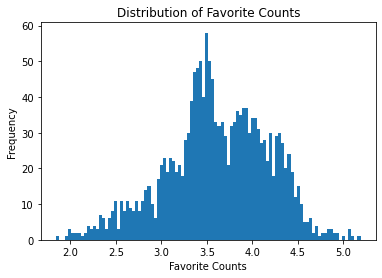

In [89]:
#ploting favorite count using a histogram chart 
plt.hist(x = df_combine.favorite_count, bins = 100)
plt.title('Distribution of Favorite Counts')
plt.xlabel('Favorite Counts')
plt.ylabel('Frequency')
plt.show()

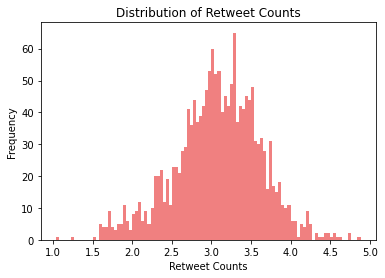

In [90]:
#ploting retweets count using a histogram chart 
plt.hist(x = df_combine.retweet_count, bins = 100 , color = 'lightcoral')
plt.title('Distribution of Retweet Counts')
plt.xlabel('Retweet Counts')
plt.ylabel('Frequency')
plt.show()

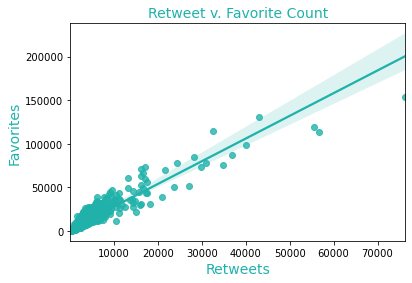

In [91]:
#Ploting a scatter plot to examin the relationship between retweet_count & favorite_count 
sns.regplot(x="retweet_count", y="favorite_count", data=twitter_archive_master , color = 'lightseagreen')
plt.title('Retweet v. Favorite Count', size=14 , color = 'lightseagreen')
plt.xlabel('Retweets', size=14 , color = 'lightseagreen')
plt.ylabel('Favorites', size=14 , color = 'lightseagreen')
plt.savefig('retweet-favorite.png');

- There is a strong positive correlation between number of retweets and favorite count.

Text(0.5, 0, 'Stage')

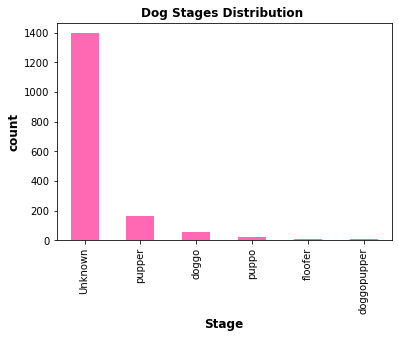

In [92]:
dog_stage = twitter_archive_master.dog_stages.value_counts()
fig, ax = plt.subplots()
dog_stage.plot(kind='bar', color='Hotpink')
ax.set_title('Dog Stages Distribution ', fontsize=12, fontweight="bold")
ax.set_ylabel('count', fontsize=12,fontweight="bold")
ax.set_xlabel('Stage', fontsize=12,fontweight="bold")

In [93]:
print('Date Range Starts at: ')
twitter_archive_master.iloc[0][['Date']]

Date Range Starts at: 


Date    2017-08-01
Name: 0, dtype: object

In [94]:
print('Date Range Ends at: ')
twitter_archive_master.iloc[-1][['Date']]

Date Range Ends at: 


Date    2015-11-15
Name: 1659, dtype: object

In [95]:
print('DataSet covers a total number of days equal =  ')
#twitter_archive_master.iloc[[-1,0]][['Date']].diff()
twitter_archive_master.loc[0]['Date'] - twitter_archive_master.iloc[-1]['Date']

DataSet covers a total number of days equal =  


datetime.timedelta(days=625)

- our Dataset covers a total of 625 days from 15 November of 2015 until 1 of August of 2017.

In [96]:
twitter_archive_master.groupby(['Month', 'Year'], sort=False).count().iloc[::-1, 0]

Month  Year
11     2015    218
12     2015    282
1      2016    137
2      2016     94
3      2016    106
4      2016     48
5      2016     48
6      2016     67
7      2016     77
8      2016     47
9      2016     55
10     2016     60
11     2016     45
12     2016     52
1      2017     59
2      2017     59
3      2017     42
4      2017     34
5      2017     36
6      2017     40
7      2017     46
8      2017      1
Name: tweet_id, dtype: int64

-The highest numbers of tweets posted were in November and December of 2015 and Januray and March of 2016.

Text(0, 0.5, 'count')

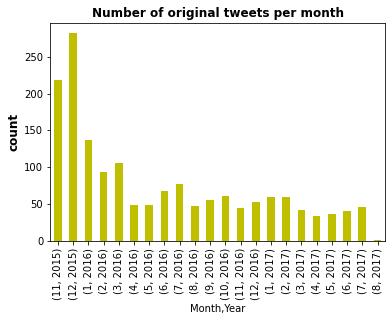

In [97]:
#ploting tweets per month using a bar chart 
tweets_per_month = twitter_archive_master.groupby(['Month', 'Year'], sort=False).count().iloc[::-1, 0]
fig, ax = plt.subplots()
tweets_per_month.plot(kind='bar', color='y')
ax.set_title('Number of original tweets per month', fontsize=12, fontweight="bold")
ax.set_ylabel('count', fontsize=12,fontweight="bold")

In [98]:
twitter_archive_master['rating_numerator'].value_counts()


12     420
11     353
10     348
13     225
9      131
8       66
7       30
14      23
6       16
5       12
4        6
3        5
2        2
165      1
24       1
144      1
26       1
27       1
44       1
45       1
60       1
75       1
80       1
84       1
88       1
99       1
121      1
143      1
0        1
Name: rating_numerator, dtype: int64

- With the igonrace to the rate denominator, I found that the dogs got usually rate between 10 to 12

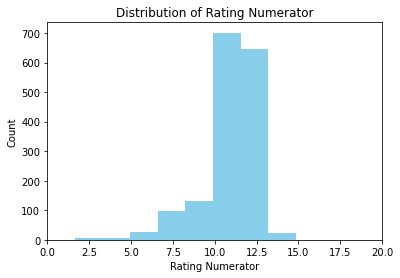

In [99]:
#ploting the rating numerator using a histgram 
plt.hist(x = twitter_archive_master.rating_numerator, bins = 100, color = "skyblue")
plt.xlim(0,20)
plt.title('Distribution of Rating Numerator')
plt.xlabel('Rating Numerator')
plt.ylabel('Count')
plt.show()

In [100]:
#ploting tweets per day using a histogram chart 
plotting_days = pd.DataFrame(twitter_archive_master.groupby('Day')['tweet_id'].count())
plotting_days

,tweet_id
Day,
1,53
2,53
3,54
4,56
5,56
6,54
7,52
8,59
9,48


Text(0, 0.5, 'Count')

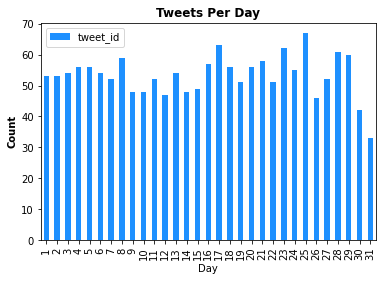

In [101]:
plotting_days.plot(kind = 'bar', color='dodgerblue')
plt.title('Tweets Per Day',fontweight = 'bold' )
plt.ylabel('Count',fontweight = 'bold')

In [102]:
twitter_archive_master['dog_stages'].value_counts()/len(twitter_archive_master) * 100

Unknown        84.452511
pupper         10.042347
doggo           3.206292
puppo           1.330913
floofer         0.483969
doggopupper     0.483969
Name: dog_stages, dtype: float64

- This reflects that most dogs has no stage (unknown) then the pupper stage comes next with 10%  and it keeps decreasing for the rest of the stages.

In [103]:
twitter_archive_master['source'].value_counts() / len(twitter_archive_master) * 100

Twitter for iPhone    98.306110
Twitter Web Client     1.209921
TweetDeck              0.483969
Name: source, dtype: float64

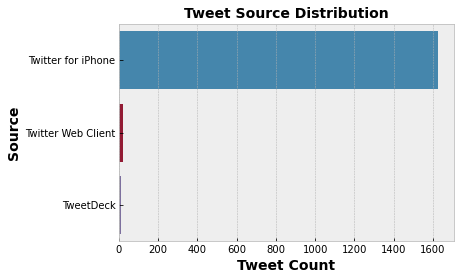

In [104]:
plt.style.use('bmh')
sns.countplot(data = twitter_archive_master, y = 'source')
plt.title('Tweet Source Distribution', fontsize=14 , fontweight ='bold')
plt.xlabel('Tweet Count', fontsize=14, fontweight ='bold')
plt.ylabel('Source', fontsize=14 , fontweight ='bold')
plt.savefig('tweet-source.png')

- It is obvious that the twitter users prefer tweeting from Iphone 98% of the time.

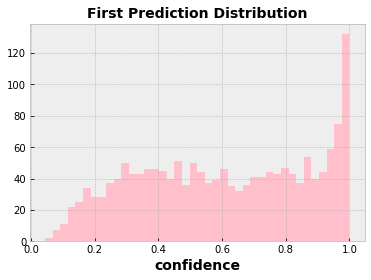

In [106]:
plt.hist(x = twitter_archive_master.Prediction_Confidence1, bins = 40, color = 'pink')
plt.title('First Prediction Distribution', fontsize=14 , fontweight ='bold')
plt.xlabel('confidence', fontsize=14, fontweight ='bold')
plt.show()

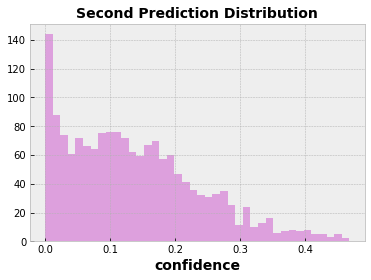

In [107]:
plt.hist(x = twitter_archive_master.Prediction_Confidence2, bins = 40, color = 'plum')
plt.title('Second Prediction Distribution', fontsize=14 , fontweight ='bold')
plt.xlabel('confidence', fontsize=14, fontweight ='bold')
plt.show()

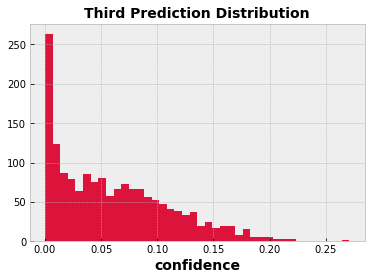

In [108]:
plt.hist(x = twitter_archive_master.Prediction_Confidence3, bins = 40 ,color = 'crimson')
plt.title('Third Prediction Distribution', fontsize=14 , fontweight ='bold')
plt.xlabel('confidence', fontsize=14, fontweight ='bold')
plt.show()

- it is clear fromt the last three histogram charts that Prediction Confidence keeps decreasing as long as we go for another one 